# Classifying Exoplanets

In this notebook, we'll continue improving our models for exoplanet classification!

We'll be:
*   Preprocessing the Dataset similar to before
*   Implementing more modern and complex machine learning architectures to see which one performs best!

## Exoplanet Classification




Previously, we were able to visualize and augment the dataset from Kepler. Now that we better understand the data that we're working with, we can begin to dive into more complex architectures to classify exoplanet stars, and the difficulties faced when doing so.

In [ ]:
%tensorflow_version 2.x
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget -q --show-progress 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, BatchNormalization, MaxPooling1D
from keras.losses import categorical_crossentropy
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

df_train = pd.read_csv('exoTrain.csv')
df_train.LABEL = df_train.LABEL -1
df_test = pd.read_csv('exoTest.csv')
df_test.LABEL = df_test.LABEL - 1

def plot_graphs(history, best):

  plt.figure(figsize=[10,4])
  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy across training\n best accuracy of %.02f'%best[1])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss across training\n best loss of %.02f'%best[0])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

def analyze_results(model, train_X, train_y, test_X, test_y):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    train_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    train_y : array-like of shape (n_samples,)
    Target values for model training.
    test_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    test_y : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    if type(model) == keras.engine.sequential.Sequential:
      train_predictions = model.predict(train_X)
      train_predictions = (train_predictions > 0.5)
      cm = confusion_matrix(train_y, train_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      plt.close()
      ConfusionMatrixDisplay.from_estimator(model,train_X,train_y)
      plt.show()

    print("Testing:")
    if type(model) == keras.engine.sequential.Sequential:
      test_predictions = model.predict(test_X)
      test_predictions = (test_predictions > 0.5)
      cm = confusion_matrix(test_y, test_predictions)
      labels = [0, 1]
      df_cm = pd.DataFrame(cm,index = labels,columns = labels)
      fig = plt.figure()
      res = sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
      #plt.yticks([1.25, 3.75], labels,va='center')
      plt.title('Confusion Matrix - TestData')
      plt.ylabel('True label')
      plt.xlabel('Predicted label')
      plt.show()
    else:
      ConfusionMatrixDisplay.from_estimator(model,test_X,test_y)

def reset(train,test):
    train_X = train.drop('LABEL', axis=1)
    train_y = train['LABEL'].values
    test_X = test.drop('LABEL', axis=1)
    test_y = test['LABEL'].values
    return train_X,train_y,test_X,test_y

train_X,train_y,test_X,test_y = reset(df_train, df_test)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
exoTrain.csv.1      100%[===================>] 250.08M   157MB/s    in 1.6s    
exoTest.csv.1       100%[===================>]  27.57M  69.9MB/s    in 0.4s    


In [ ]:


def smote(a,b):
    model = SMOTE()
    X,y = model.fit_resample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    train_X = np.abs(np.fft.fft(df1, axis=1))
    test_X = np.abs(np.fft.fft(df2, axis=1))
    return train_X,test_X

def norm(df1,df2):
    train_X = normalize(df1)
    test_X = normalize(df2)
    return train_X,test_X

def robust(df1,df2):
    scaler = RobustScaler()
    train_X = scaler.fit_transform(df1)
    test_X = scaler.transform(df2)
    return train_X,test_X

fourier_train_X, fourier_test_X = fourier(train_X, test_X)
savgol_train_X, savgol_test_X = savgol(fourier_train_X, fourier_test_X)
norm_train_X, norm_test_X = norm(savgol_train_X,savgol_test_X)
robust_train_X, robust_test_X = robust(norm_train_X, norm_test_X)
smote_train_X,smote_train_y = smote(robust_train_X, train_y)

# Here we're adding the generated, augmented data onto the testing data
aug_train_X, new_X_test_data, aug_train_y, new_y_test_data = train_test_split(smote_train_X, smote_train_y, test_size=0.3)
aug_test_X = np.concatenate((robust_test_X, new_X_test_data), axis=0)
aug_test_y = np.concatenate((test_y, new_y_test_data), axis=0)


##MLP

MLP stands for Multi-layer Perceptron, a specific kind of simple neural network. Thankfully, this is something that Sklearn supports, and it's already imported as MLPClassifier.


![visual](https://s3.amazonaws.com/stackabuse/media/intro-to-neural-networks-scikit-learn-3.png)

In [ ]:

model = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(10))

0.9995756718528995
0.9952777777777778
-------------------------------------------
Model Results

Training:


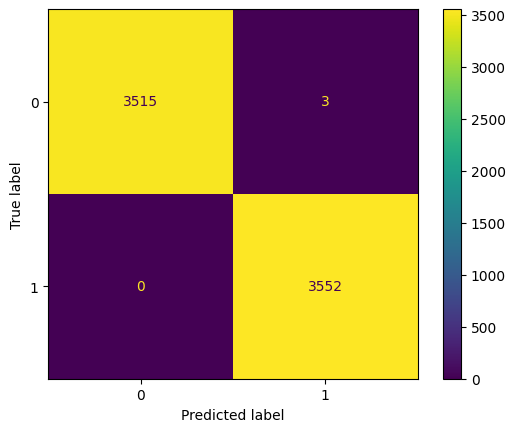

Testing:


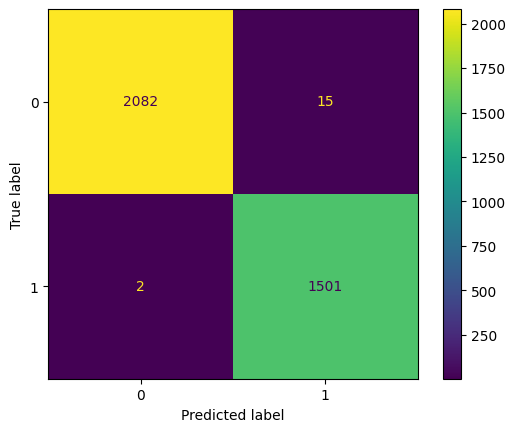

In [ ]:
model.fit(aug_train_X, aug_train_y)

train_predictions = model.predict(aug_train_X)
test_predictions = model.predict(aug_test_X)
print(accuracy_score(aug_train_y, train_predictions))
print(accuracy_score(aug_test_y, test_predictions))
analyze_results(model=model, train_X=aug_train_X, train_y=aug_train_y, test_X=aug_test_X, test_y=aug_test_y)

##Neural Networks (Tensorflow and Keras)

In [ ]:

model = Sequential()


model.add(Dense(10, input_shape=(3197,), activation = "relu"))
model.add(Dense(1, activation='sigmoid'))

# we finalize the model by "compiling" it and defining some other hyperparameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                31980     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 31,991
Trainable params: 31,991
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 64
epochs = 20
validation_data = (aug_test_X, aug_test_y)
verbose = 1
shuffle = True

history = model.fit(aug_train_X, aug_train_y, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=validation_data, shuffle=shuffle)

Epoch 1/20
111/111 [==============================] - 6s 8ms/step - loss: 0.1696 - accuracy: 0.9406 - val_loss: 0.0809 - val_accuracy: 0.9728
Epoch 2/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0550 - accuracy: 0.9829 - val_loss: 0.0473 - val_accuracy: 0.9833
Epoch 3/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0322 - accuracy: 0.9902 - val_loss: 0.0476 - val_accuracy: 0.9822
Epoch 4/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0270 - accuracy: 0.9921 - val_loss: 0.0280 - val_accuracy: 0.9892
Epoch 5/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0158 - accuracy: 0.9959 - val_loss: 0.0365 - val_accuracy: 0.9847
Epoch 6/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 0.0259 - val_accuracy: 0.9922
Epoch 7/20
111/111 [==============================] - 1s 5ms/step - loss: 0.0158 - accuracy: 0.9950 - val_loss: 0.0226 - val_accuracy: 0.9928
Epoch 

57/57 [==============================] - 0s 4ms/step - loss: 0.0278 - accuracy: 0.9936


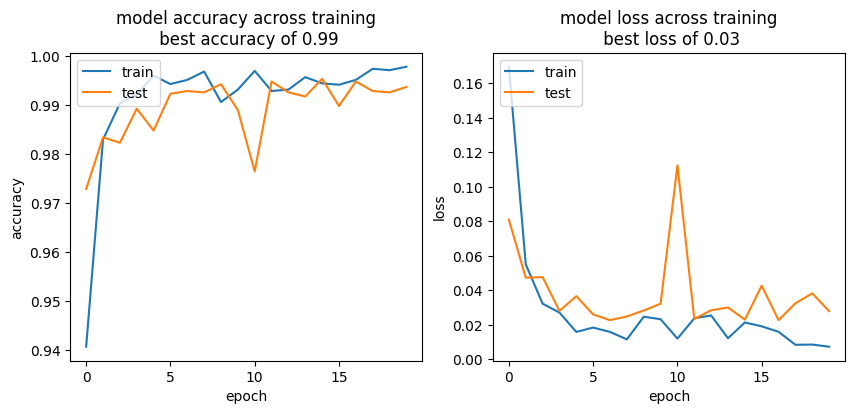

-------------------------------------------
Model Results

Training:
221/221 [==============================] - 1s 4ms/step


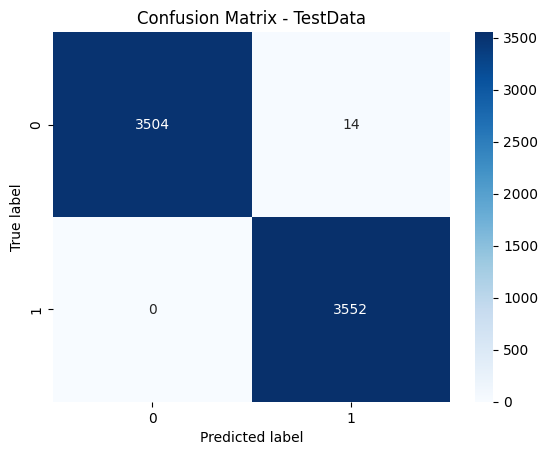

Testing:
113/113 [==============================] - 0s 3ms/step


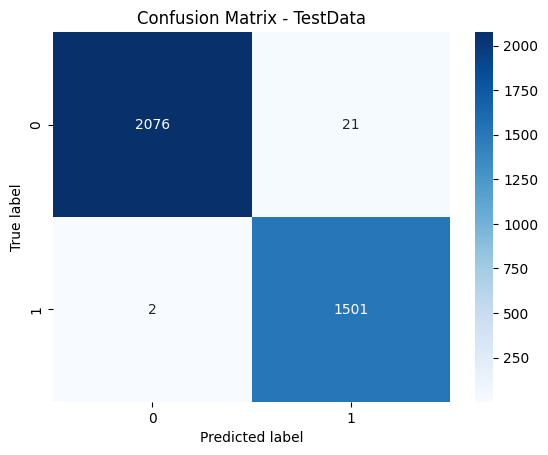

In [ ]:
performance = model.evaluate(aug_test_X, aug_test_y, batch_size=batch_size)
plot_graphs(history, performance)

analyze_results(model=model, train_X=aug_train_X, train_y=aug_train_y, test_X=aug_test_X, test_y=aug_test_y)##############

## Convolutional Neural Network (CNN)

One potential fault of our previous approach is memorizing the placement of specific patterns in the data. Although we were able to achieve great levels of accuracy, we might benefit from an architecture that can make decisions based on patterns no matter where they occur in the sample - for example, if we started measuring flux earlier or later

![](https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg)

In [ ]:
cnn_aug_train_X = np.expand_dims(aug_train_X, axis=2)
cnn_aug_train_y = aug_train_y


cnn_train_X = np.expand_dims(train_X, axis=2)
cnn_train_y = train_y


cnn_aug_test_X = np.expand_dims(aug_test_X, axis=2)
cnn_aug_test_y = aug_test_y

cnn_test_X = np.expand_dims(test_X, axis=2)
cnn_test_y = test_y


In [ ]:
print(cnn_aug_train_X.shape)
print(cnn_aug_test_X.shape)
print(cnn_aug_train_y.shape)
print(cnn_aug_test_y.shape)

(7070, 3197, 1)
(3600, 3197, 1)
(7070,)
(3600,)


In [ ]:
from keras.layers.convolutional.conv1d import Convolution1D
# Create model

# initialize our model
model = Sequential()
input_shape = [3197, 1]

model = Sequential()
input_shape = [3197, 1]

cnn_layer_1 = Conv1D(8, 5, activation='relu', input_shape=input_shape, padding='same')
cnn_layer_2 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_3 = Conv1D(16, 3, activation='relu', padding='same')
cnn_layer_4 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_5 = Flatten()
cnn_layer_6 = Dense(1, activation='sigmoid')

# then we add a "Dense" (i.e. fully connected) layer
model.add(cnn_layer_1) # for the first layer we specify the input dimensions
model.add(cnn_layer_2)
model.add(cnn_layer_3)
model.add(cnn_layer_4)
model.add(cnn_layer_5)
model.add(cnn_layer_6)
####################

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the Model

batch_size = 64
epochs = 20
validation_data = (cnn_aug_test_X, cnn_aug_test_y)
verbose = 1
shuffle = True

history = model.fit(cnn_aug_train_X, cnn_aug_train_y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                            validation_data=validation_data, shuffle=shuffle)
####################

Epoch 1/20
111/111 [==============================] - 8s 12ms/step - loss: 0.2860 - accuracy: 0.8750 - val_loss: 0.1330 - val_accuracy: 0.9625
Epoch 2/20
111/111 [==============================] - 1s 9ms/step - loss: 0.0822 - accuracy: 0.9772 - val_loss: 0.0802 - val_accuracy: 0.9744
Epoch 3/20
111/111 [==============================] - 1s 9ms/step - loss: 0.0489 - accuracy: 0.9878 - val_loss: 0.0469 - val_accuracy: 0.9900
Epoch 4/20
111/111 [==============================] - 1s 7ms/step - loss: 0.0339 - accuracy: 0.9918 - val_loss: 0.0453 - val_accuracy: 0.9853
Epoch 5/20
111/111 [==============================] - 1s 8ms/step - loss: 0.0249 - accuracy: 0.9926 - val_loss: 0.0373 - val_accuracy: 0.9900
Epoch 6/20
111/111 [==============================] - 1s 6ms/step - loss: 0.0185 - accuracy: 0.9950 - val_loss: 0.0352 - val_accuracy: 0.9908
Epoch 7/20
111/111 [==============================] - 1s 6ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0390 - val_accuracy: 0.9897
Epoch

57/57 [==============================] - 0s 4ms/step - loss: 0.0254 - accuracy: 0.9978


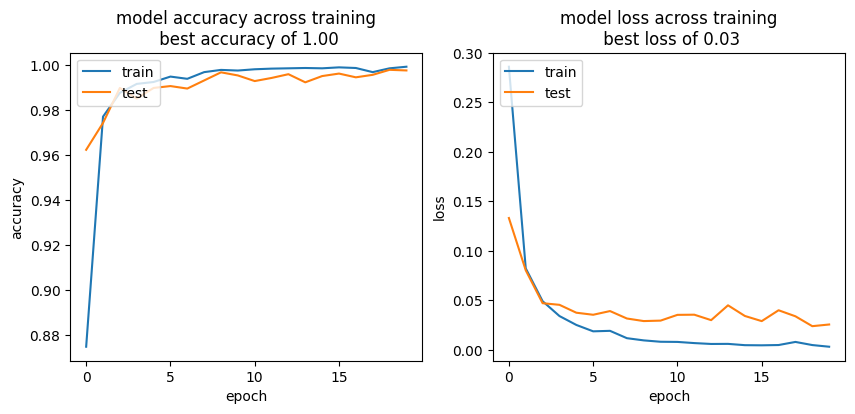

-------------------------------------------
Model Results

Training:
221/221 [==============================] - 1s 2ms/step


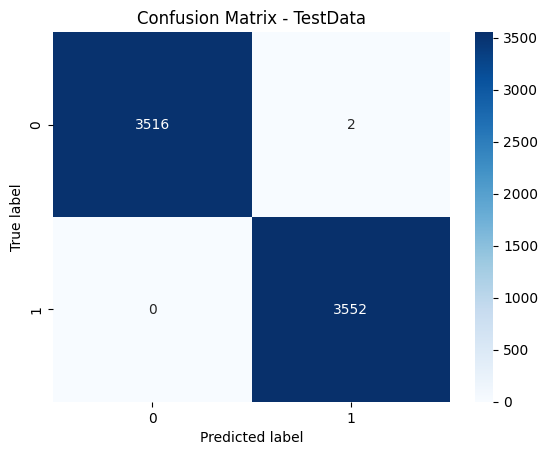

Testing:
113/113 [==============================] - 0s 2ms/step


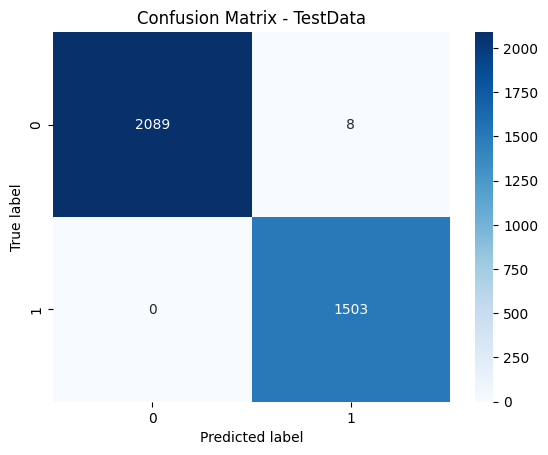

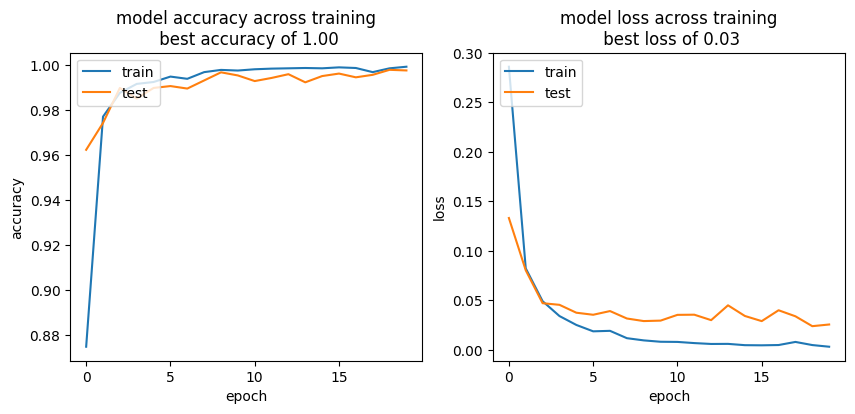

-------------------------------------------
Model Results

Training:
221/221 [==============================] - 0s 2ms/step


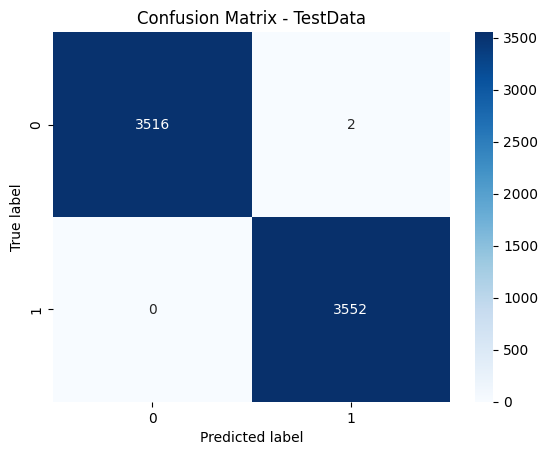

Testing:
113/113 [==============================] - 0s 2ms/step


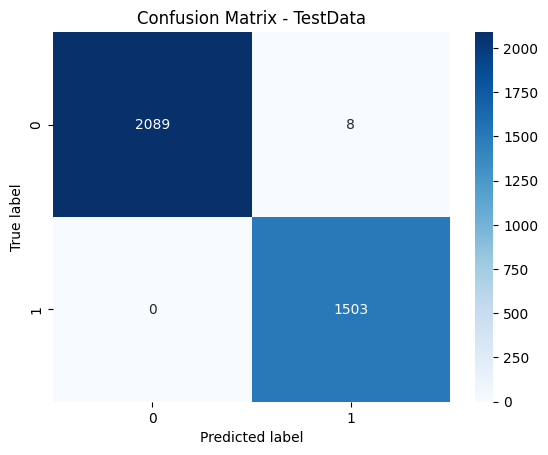

In [ ]:

performance = model.evaluate(cnn_aug_test_X, cnn_aug_test_y, batch_size=batch_size)
plot_graphs(history, performance)

##############
analyze_results(model=model, train_X=cnn_aug_train_X, train_y=cnn_aug_train_y, test_X=cnn_aug_test_X, test_y=cnn_aug_test_y)
##############performance = model.evaluate(cnn_aug_test_X, cnn_aug_test_y, batch_size=batch_size)
plot_graphs(history, performance)

##############
analyze_results(model=model, train_X=cnn_aug_train_X, train_y=cnn_aug_train_y, test_X=cnn_aug_test_X, test_y=cnn_aug_test_y)
##############

In [ ]:
model = Sequential()
input_shape = [3197, 1]

cnn_layer_1 = Conv1D(8, 5, activation='relu', input_shape=input_shape, padding='same')
cnn_layer_2 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_3 = Conv1D(16, 3, activation='relu', padding='same')
cnn_layer_4 = MaxPooling1D(pool_size=4, strides=4, padding='same')
cnn_layer_5 = Flatten()
cnn_layer_6 = Dense(1, activation='sigmoid')
cnn_layer_7 = Dropout(1, padding='same')

model.add(cnn_layer_1)
model.add(cnn_layer_2)
model.add(cnn_layer_3)
model.add(cnn_layer_4)
model.add(cnn_layer_5)
model.add(cnn_layer_6)
model.add(cnn_layer_7)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

performance = model.evaluate(cnn_aug_test_X, cnn_aug_test_y, batch_size=batch_size)
plot_graphs(history, performance)

##############
analyze_results(model=model, train_X=cnn_aug_train_X, train_y=cnn_aug_train_y, test_X=cnn_aug_test_X, test_y=cnn_aug_test_y)
##############performance = model.evaluate(cnn_aug_test_X, cnn_aug_test_y, batch_size=batch_size)
plot_graphs(history, performance)

##############
analyze_results(model=model, train_X=cnn_aug_train_X, train_y=cnn_aug_train_y, test_X=cnn_aug_test_X, test_y=cnn_aug_test_y)
##############

TypeError: ignored